In [ ]:
####git에 올릴 버전####

SyntaxError: invalid syntax (3930689032.py, line 2)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, precision_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
)
import joblib

In [ ]:
################################
#결측치를 제거한 후, 이상치 제거를 하지 않은 버전의 데이터를 사용
#################################

In [9]:
# Load dataset
data = pd.read_csv("data/waze_dataset.csv", index_col=0)

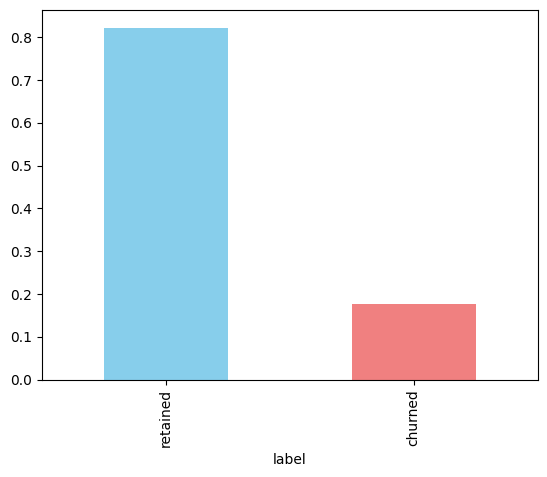

In [10]:
# Target 분포 확인
data['label'].value_counts(normalize = True).plot(kind = 'bar', color = ['skyblue', 'lightcoral']);

In [3]:
# DataLoad 함수

# %%writefile module/ml_data.py

import pandas as pd

def load_dataset(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.lower()
    X = data.drop(["id", "label"], axis=1)
    y = data['label']
    
    return X, y

# dataset 준비
from sklearn.model_selection import train_test_split

# X, y 분리
X, y = load_dataset("data/preprocessed.csv")

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)
# train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [41]:
print(X.head()) 
print(y.head())

   sessions  drives  total_sessions  n_days_after_onboarding  \
0       283     226      296.748273                     2276   
1       133     107      326.896596                     1225   
2       114      95      135.522926                     2651   
3        49      40       67.589221                       15   
4        84      68      168.247020                     1562   

   total_navigations_fav1  total_navigations_fav2  driven_km_drives  \
0                     208                       0       2628.845068   
1                      19                      64      13715.920550   
2                       0                       0       3059.148818   
3                     322                       7        913.591123   
4                     166                       5       3950.202008   

   duration_minutes_drives  activity_days  driving_days  device_android  \
0              1985.775061             28            19            True   
1              3160.472914            

In [4]:
# Baseline model
models = [
    ("LR", LogisticRegression(random_state=0, max_iter=3000)),
    ("GBM", GradientBoostingClassifier(random_state=0)),
    ("RF", RandomForestClassifier(random_state=0)),
    ("XGB", XGBClassifier(random_state=0))
]

In [5]:
# 학습

baseline_result_train_dict = {}
baseline_result_valid_dict = {}


for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    pred_valid = model.predict(X_valid)
    pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    accuracy_valid = accuracy_score(y_valid, pred_valid)
    precision_valid = precision_score(y_valid, pred_valid)
    recall_valid = recall_score(y_valid, pred_valid)
    f1_valid = f1_score(y_valid, pred_valid)
    auc_valid = roc_auc_score(y_valid, pred_proba_valid)
    
    baseline_result_valid_dict[name] = [accuracy_valid, precision_valid, recall_valid, f1_valid, auc_valid]

Training LR...


/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training GBM...
Training RF...
Training XGB...


In [6]:
# result

pd.DataFrame(baseline_result_valid_dict, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

,LR,GBM,RF,XGB
accuracy,0.828322,0.824126,0.822378,0.811189
precision,0.836831,0.834902,0.835821,0.838625
recall,0.983000,0.980025,0.975776,0.954101
f1,0.904045,0.901662,0.900392,0.892644
roc-auc,0.758724,0.752835,0.733010,0.709396


In [26]:
#rou-auc는 불균형데이터에서 모델의 분류 능력을 평가할 때 유용
#rou-auc 기준으로 LR과 GBM의 성능이 높으므로 둘을 기준으로 하이퍼파라미터 튜닝 진행

In [ ]:
######################
####tuning
#####################

In [7]:

param_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000] #크게의미x
}

param_gbm = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': range(1, 6),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Initialize RandomizedSearchCV for each model
random_search_lr = RandomizedSearchCV(LogisticRegression(random_state=0), param_lr, cv=4, scoring='roc_auc', n_jobs=-1, n_iter=60, random_state=0)
random_search_gbm = RandomizedSearchCV(GradientBoostingClassifier(random_state=0), param_gbm, cv=4, scoring='roc_auc', n_jobs=-1, n_iter=60, random_state=0)

print("LogisticRegression 튜닝...")
random_search_lr.fit(X_train, y_train);

print("GradientBoostingClassifier 튜닝...")
random_search_gbm.fit(X_train, y_train)


LogisticRegression 튜닝...


/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linea

GradientBoostingClassifier 튜닝...


RandomizedSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2, 0.3, 0.5],
                                        'max_depth': range(1, 6),
                                        'n_estimators': [100, 500, 1000, 2000],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=0, scoring='roc_auc')

In [15]:
#tuning result
print("LogisticRegression Best parameters:", random_search_lr.best_params_)
print("GradientBoostingClassifier Best parameters:", random_search_gbm.best_params_)


print("LogisticRegression Best score:", random_search_lr.best_score_)
print("GradientBoostingClassifier Best score:", random_search_gbm.best_score_)

LogisticRegression Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 0.01}
GradientBoostingClassifier Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.05}
LogisticRegression Best score: 0.7563884395173348
GradientBoostingClassifier Best score: 0.7521515958344263


In [9]:
# 최종 모델

best_lr = random_search_lr.best_estimator_
best_gbm = random_search_gbm.best_estimator_

joblib.dump(best_lr, 'model/best_lr.pkl')
joblib.dump(best_gbm, 'model/best_gbm.pkl')

print("Models saved successfully.")

Models saved successfully.


In [25]:
###################
####임계값 조정####
###################

In [22]:
# 임계값 리스트 정의
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# 결과 저장 딕셔너리 초기화
baseline_result_valid_dict = {}

for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # 예측 확률 생성
    pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    # 각 임계값에 대해 성능 평가
    for threshold in thresholds:
        # 임계값 적용하여 예측 생성
        pred_valid = (pred_proba_valid >= threshold).astype(int)
        
        # 성능 평가
        accuracy_valid = accuracy_score(y_valid, pred_valid)
        precision_valid = precision_score(y_valid, pred_valid)
        recall_valid = recall_score(y_valid, pred_valid)
        f1_valid = f1_score(y_valid, pred_valid)
        auc_valid = roc_auc_score(y_valid, pred_proba_valid)  # ROC-AUC는 확률 기반으로 계산
        
        # 결과 저장 (각 모델 이름과 임계값을 키로 사용)
        baseline_result_valid_dict[(name, threshold)] = [
            accuracy_valid, precision_valid, recall_valid, f1_valid, auc_valid
        ]

# 결과 출력
import pandas as pd
results_df = pd.DataFrame(baseline_result_valid_dict, index=["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]).T
print(results_df)

Training LR...
Training GBM...
Training RF...
Training XGB...
         Accuracy  Precision    Recall  F1 Score   ROC-AUC
LR  0.3  0.822378   0.822891  0.999150  0.902495  0.758722
    0.4  0.823427   0.825581  0.995750  0.902716  0.758722
    0.5  0.828322   0.836831  0.983000  0.904045  0.758722
    0.6  0.825175   0.855935  0.946876  0.899112  0.758722
    0.7  0.797902   0.883701  0.868678  0.876125  0.758722
GBM 0.3  0.823077   0.823241  0.999575  0.902879  0.752880
    0.4  0.824126   0.825934  0.996175  0.903102  0.752880
    0.5  0.824476   0.834962  0.980450  0.901876  0.752880
    0.6  0.827273   0.855178  0.951126  0.900604  0.752880
    0.7  0.793357   0.881055  0.865703  0.873312  0.752880
RF  0.3  0.822378   0.822665  0.999575  0.902533  0.732124
    0.4  0.823776   0.824728  0.997875  0.903077  0.732124
    0.5  0.822727   0.834663  0.978326  0.900802  0.732124
    0.6  0.812587   0.854467  0.930727  0.890968  0.732124
    0.7  0.770280   0.877560  0.837654  0.857143  0.7

In [20]:
#roc-auc는 임계값 조정과 상관없기 때문에 값이 변하지 않음

In [ ]:
##################################
###Feature importance 확인####
##################################

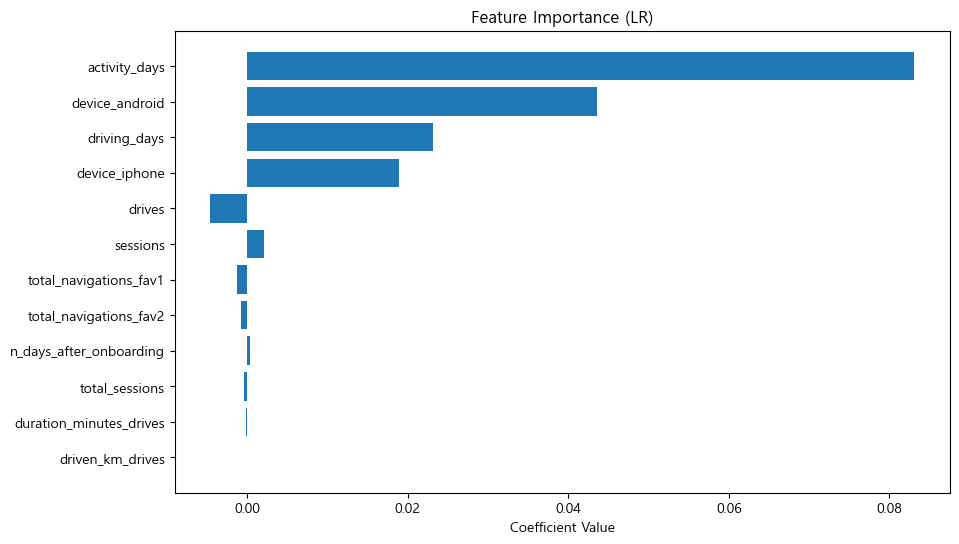

In [29]:
# LR feature importance
import matplotlib.pyplot as plt
import numpy as np

model_lr = LogisticRegression(random_state=0, max_iter=3000)

model_lr.fit(X_train, y_train)

# coefficient

coefficients = model_lr.coef_[0]
indices = np.argsort(np.abs(coefficients))  
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (LR)")
plt.barh(range(len(indices)), coefficients[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Coefficient Value")
plt.show()

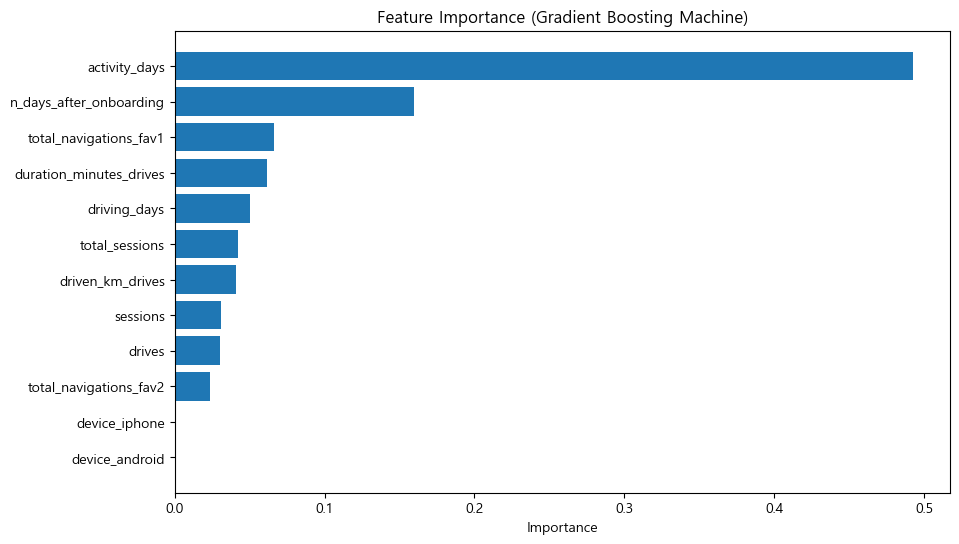

In [30]:
# gbm feature importance
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting 모델 학습
model_gbm = GradientBoostingClassifier(random_state=0)

model_gbm.fit(X_train, y_train)

# feature_importances_를 통한 피처 중요도 시각화
importance = model_gbm.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Gradient Boosting Machine)")
plt.barh(range(len(indices)), importance[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Importance")
plt.show()


In [ ]:
# GBM feature importance 기반으로 무의미하다고 판단되는 feature(device) 삭제 후 학습

In [10]:

# DataLoad 함수

# %%writefile module/ml_data.py

import pandas as pd

def load_dataset(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.lower()
    X = data.drop(["id", "label"], axis=1)
    y = data['label']
    
    return X, y

# dataset 준비
from sklearn.model_selection import train_test_split

# X, y 분리
X, y = load_dataset("data/preprocessed_device_outlier.csv")

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=0)
# train/valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [11]:
# Baseline model
models = [
    ("LR", LogisticRegression(random_state=0, max_iter=3000)),
    ("GBM", GradientBoostingClassifier(random_state=0)),
    ("RF", RandomForestClassifier(random_state=0)),
    ("XGB", XGBClassifier(random_state=0))
]

In [12]:
# 학습

baseline_result_train_dict = {}
baseline_result_valid_dict = {}


for name, model in models:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    pred_valid = model.predict(X_valid)
    pred_proba_valid = model.predict_proba(X_valid)[:, 1]

    accuracy_valid = accuracy_score(y_valid, pred_valid)
    precision_valid = precision_score(y_valid, pred_valid)
    recall_valid = recall_score(y_valid, pred_valid)
    f1_valid = f1_score(y_valid, pred_valid)
    auc_valid = roc_auc_score(y_valid, pred_proba_valid)
    
    baseline_result_valid_dict[name] = [accuracy_valid, precision_valid, recall_valid, f1_valid, auc_valid]

Training LR...
Training GBM...
Training RF...
Training XGB...


In [48]:
# result

pd.DataFrame(baseline_result_valid_dict, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

,LR,GBM,RF,XGB
accuracy,0.828322,0.824126,0.823427,0.810140
precision,0.836831,0.834902,0.838462,0.840995
recall,0.983000,0.980025,0.972801,0.948576
f1,0.904045,0.901662,0.900649,0.891552
roc-auc,0.758795,0.752828,0.731352,0.699785


In [ ]:
# device 삭제했음에도 유의미한 차이가 보이지 않음
# 하이퍼파라미터 조정

In [13]:
param_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000] #크게의미x
}

test_results = {}

param_gbm = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': range(1, 6),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]
}

# Initialize RandomizedSearchCV for each model
random_search_lr = RandomizedSearchCV(LogisticRegression(random_state=0), param_lr, cv=4, scoring='roc_auc', n_jobs=-1, n_iter=60, random_state=0)
random_search_gbm = RandomizedSearchCV(GradientBoostingClassifier(random_state=0), param_gbm, cv=4, scoring='roc_auc', n_jobs=-1, n_iter=60, random_state=0)

print("LogisticRegression 튜닝...")
random_search_lr.fit(X_train, y_train);

print("GradientBoostingClassifier 튜닝...")
random_search_gbm.fit(X_train, y_train)



LogisticRegression 튜닝...


/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linea

GradientBoostingClassifier 튜닝...


RandomizedSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2, 0.3, 0.5],
                                        'max_depth': range(1, 6),
                                        'n_estimators': [100, 500, 1000, 2000],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=0, scoring='roc_auc')

In [ ]:
#tuning result
print("LogisticRegression Best parameters:", random_search_lr.best_params_)
print("GradientBoostingClassifier Best parameters:", random_search_gbm.best_params_)


print("LogisticRegression Best score:", random_search_lr.best_score_)
print("GradientBoostingClassifier Best score:", random_search_gbm.best_score_)

pd.DataFrame(test_results, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

LogisticRegression Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 0.01}
GradientBoostingClassifier Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.05}
LogisticRegression Best score: 0.7563884395173348
GradientBoostingClassifier Best score: 0.7521515958344263


In [14]:
# 최종 모델

best_lr = random_search_lr.best_estimator_
best_gbm = random_search_gbm.best_estimator_

In [15]:
# 최종 테스트
best_models = [
    ("LogisticRegression", best_lr),
    ("GradientBoostingClassifier", best_gbm)
]

test_results = {}

for name, model in best_models:
    print(f"평가 {name}...")
    pred_test = model.predict(X_test)
    pred_proba_test = model.predict_proba(X_test)[:, 1]

    accuracy_test = accuracy_score(y_test, pred_test)
    precision_test = precision_score(y_test, pred_test)
    recall_test = recall_score(y_test, pred_test)
    f1_test = f1_score(y_test, pred_test)
    auc_test = roc_auc_score(y_test, pred_proba_test)
    
    test_results[name] = [accuracy_test, precision_test, recall_test, f1_test, auc_test]

평가 LogisticRegression...
평가 GradientBoostingClassifier...


In [16]:
#결과
pd.DataFrame(test_results, index=['accuracy', 'precision', 'recall', 'f1', 'roc-auc'])

,LogisticRegression,GradientBoostingClassifier
accuracy,0.826573,0.826224
precision,0.834113,0.834053
recall,0.985125,0.984700
f1,0.903352,0.903138
roc-auc,0.744900,0.739423


In [18]:
#모델 저장

joblib.dump(best_lr, 'model/best_lr_nodevice.pkl')
joblib.dump(best_gbm, 'model/best_gbm_nodevice.pkl')

print("Models saved successfully.")

Models saved successfully.


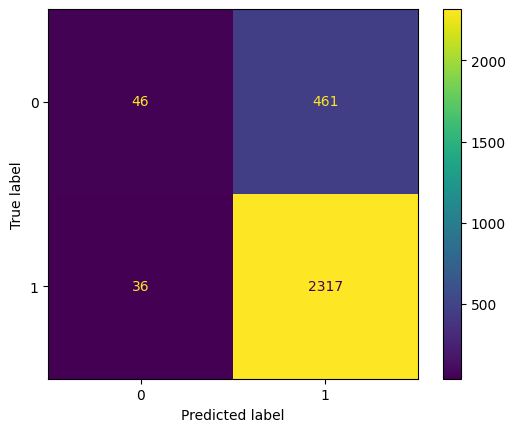

In [54]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.savefig('image/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()